# Image Segmentation and Feature Extraction Workflow

This notebook demonstrates an image segmentation workflow using microscopy images from the BBBC007v1 image set (Jones et al., Proc. ICCV Workshop on Computer Vision for Biomedical Image Applications, 2005), available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012]. The workflow includes segmentation, feature extraction, and visualization of feature relationships.

## Steps:
1. Import necessary libraries
2. Load the images and their corresponding label images
3. Perform image segmentation
4. Extract features from the segmented images
5. Visualize relationships between the features
6. Identify strongly and weakly correlated features
7. Save the segmentation results and the extracted features
8. Measure the quality of the segmentation results
9. Document the data and algorithms used

In [1]:
# Import necessary libraries
import os
import tifffile as tiff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops_table
from skimage.morphology import remove_small_objects
import stackview
from the_segmentation_game import metrics

### Installation instructions
The required libraries can be installed using the following command:
```bash
pip install tifffile numpy pandas matplotlib scikit-image stackview the_segmentation_game
```

### Loading images and their corresponding label images

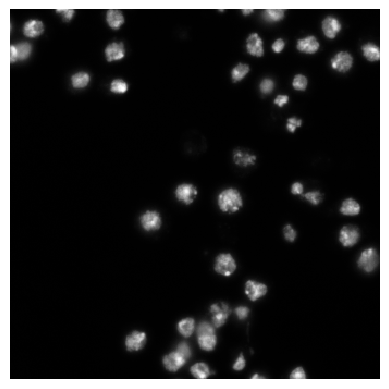

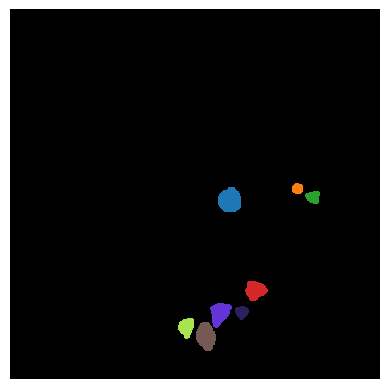

In [2]:
# Define folder paths
image_folder = '../05b_quality_assurance/data/BBBC007_batch/'
label_folder = '../05b_quality_assurance/data/BBBC007_sparse_instance_annotation/'

# Get list of files
image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
label_files = [f for f in os.listdir(label_folder) if f.endswith('.tif')]

# Load images and labels
images = [tiff.imread(os.path.join(image_folder, file)) for file in image_files]
labels = [tiff.imread(os.path.join(label_folder, file)) for file in label_files]

# Display an example image and its label
stackview.imshow(images[0])
stackview.imshow(labels[0])

### Image segmentation using a thresholding method followed by post-processing steps
Segmentation is performed using a simple thresholding method followed by removing small objects and clearing objects touching the image border.

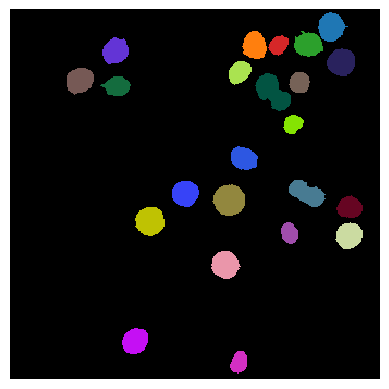

In [3]:
segmented_images = []
for image in images:
    # Apply thresholding
    binary = image > np.mean(image)
    # Remove small objects
    binary = remove_small_objects(binary, min_size=64)
    # Clear objects connected to the border
    cleared = clear_border(binary)
    # Label the image
    labeled_image = label(cleared)
    segmented_images.append(labeled_image)

# Display the result of segmentation for the first image
stackview.imshow(segmented_images[0])

### Extract features from the segmented images
Features such as area, perimeter, and eccentricity will be extracted using the `regionprops_table` function from the `skimage` library.

In [4]:
features_list = []
for segmented_image in segmented_images:
    properties = ['area', 'perimeter', 'eccentricity']
    features = regionprops_table(segmented_image, properties=properties)
    features_list.append(pd.DataFrame(features))

# Display features of the first image
display(features_list[0])

,area,perimeter,eccentricity
0,505.0,85.219300,0.416536
1,448.0,80.183766,0.560025
2,469.0,86.219300,0.552485
3,243.0,57.941125,0.634556
4,454.0,79.597980,0.502911
5,519.0,83.012193,0.293079
6,336.0,67.355339,0.660624
7,481.0,81.355339,0.541653
8,297.0,62.284271,0.285418
9,676.0,113.982756,0.838178


### Visualize relationships between the features

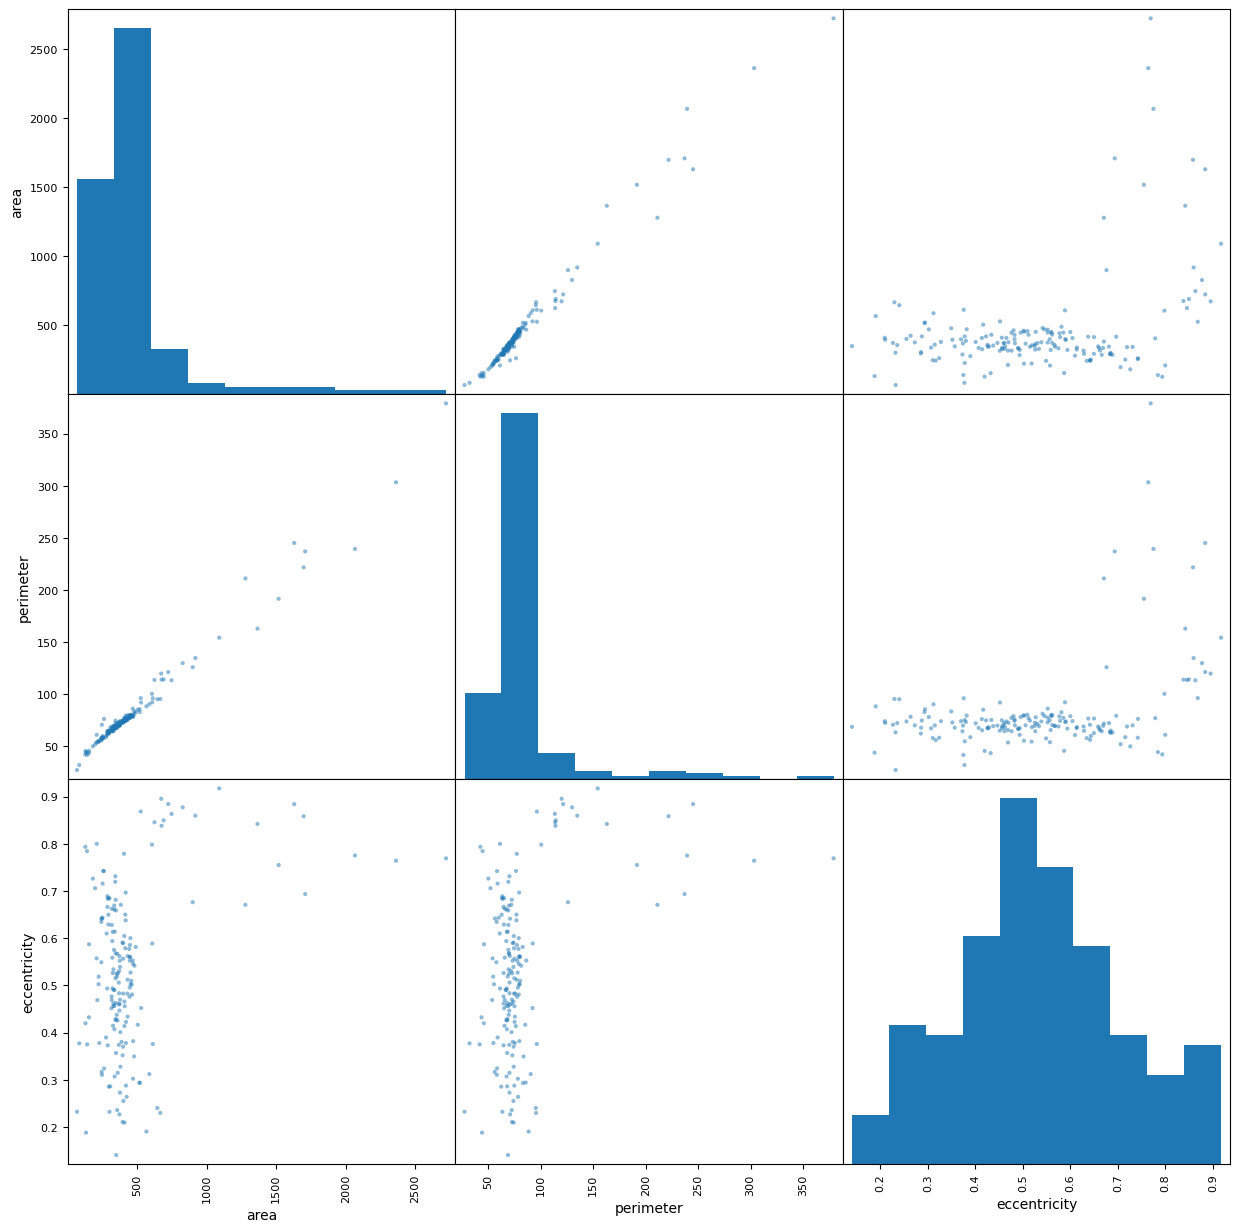

In [5]:
# Combine features from all images into a single DataFrame
all_features = pd.concat(features_list, ignore_index=True)

# Generate pair plot
pd.plotting.scatter_matrix(all_features, figsize=(15, 15))
plt.show()

### Identify strongly and weakly correlated features

,area,perimeter,eccentricity
area,1.000000,0.989719,0.377613
perimeter,0.989719,1.000000,0.407803
eccentricity,0.377613,0.407803,1.000000


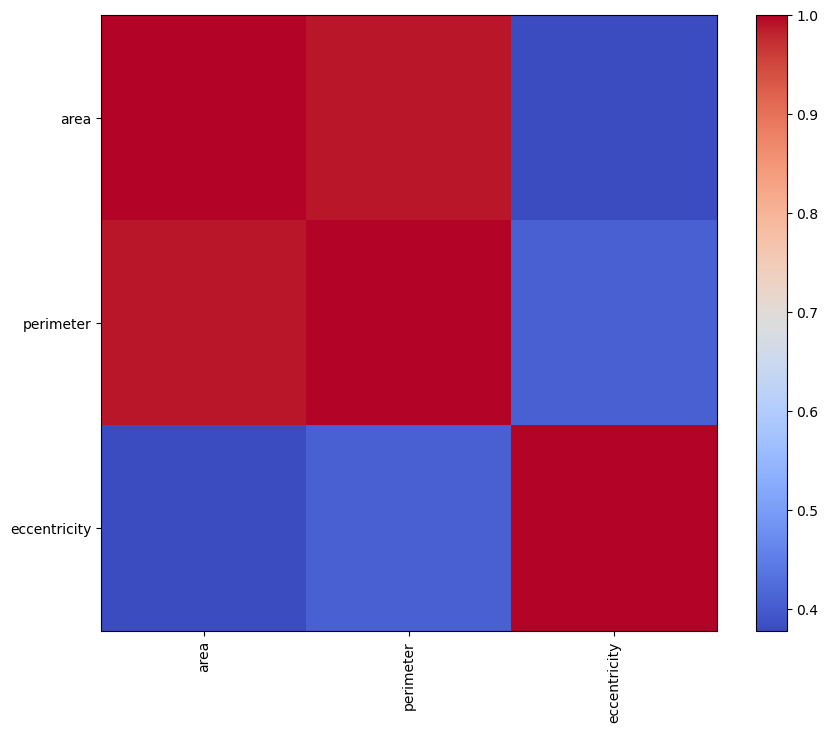

In [6]:
# Compute the correlation matrix
corr_matrix = all_features.corr()

# Display the correlation matrix
display(corr_matrix)

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()

### Save segmentation results and features

In [7]:
output_dir = '../output/'
os.makedirs(output_dir, exist_ok=True)

# Save segmented images
for i, segmented_image in enumerate(segmented_images):
    tiff.imwrite(os.path.join(output_dir, f'segmented_{i}.tif'), segmented_image)

# Save features
all_features.to_csv(os.path.join(output_dir, 'features.csv'), index=False)

### Measure the quality of the segmentation results
The quality of the segmentation results is measured using the sparse Jaccard index.

In [8]:
quality_scores = []
for i in range(len(labels)):
    reference_labels = labels[i]
    segmented_labels = segmented_images[i]
    score = metrics.jaccard_index_sparse(reference_labels, segmented_labels)
    quality_scores.append(score)

# Display quality scores
print(quality_scores)

[0.12468005540955758, 0.217229518524384, 0.32456910730533933, 0.41014385757487465, 0.3846853340928547, 0.0]


### Documentation
- **Installation instructions:** The required libraries can be installed using `pip install tifffile numpy pandas matplotlib scikit-image stackview the_segmentation_game`
- **User guide:** Place images in the specified `image_folder` and corresponding label images in the `label_folder`. Execute the notebook to perform segmentation, feature extraction, and analysis.
- **Documentation of used data:** We used BBBC007v1 image set version 1 (Jones et al., Proc. ICCV Workshop on Computer Vision for Biomedical Image Applications, 2005), available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012].
- **Explanation of the used algorithms:**
  - **Thresholding:** We applied a global threshold based on the mean pixel intensity of the image to separate foreground from background.
  - **Post-processing:** Small objects were removed, and objects touching the image border were cleared for clean segmentation.
  - **Region Properties Extraction:** Features such as area, perimeter, and eccentricity were extracted from the segmented objects using `regionprops_table` function from `skimage.measure` module.